In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F

from competence_estimation.utils import load_data, get_network_weights, mix_open
from competence_estimation.scores  import create_score_function
from competence_estimation.metrics  import compute_metric

import pandas as pd
import matplotlib.pyplot as plt

# Short Introduction

The following files are required:
* {x}_id_train.pt
* {x}_id_val.pt
* {x}_id_test.pt
where x = features, logits, labels

and the same for ood samples:
* {x}_ood
where x = features, logits, labels

Additionally we require the weights w and biases b of the last layer

# Data and Config Loading

In [10]:
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)

# Create Plot

In [11]:
# Here you have to include your own path
# dataset_path = "/home/DATA/ITWM/lorenzp/"
dataset_path = "/home/lorenzp/workspace/competence_estimation/features/cifar10"
# algorithm = "ERM"
model = "resnet18"
mode = "benign"

w = torch.load(f"{dataset_path}/{mode}/{model}_W.pt")
b = torch.load(f"{dataset_path}/{mode}/{model}_b.pt")

print(w.shape, b.shape)

# Features/logits/labels Trainings datad
features_id_train =  torch.load(f"{dataset_path}/{mode}/features_{mode}_{model}_train.pt")[:30000]
logits_id_train = torch.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_train.pt")[:30000]
labels_id_train =  torch.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_train.pt")[:30000]

# Features/logits/labels Validation data
features_id_val = torch.load(f"{dataset_path}/{mode}/features_{mode}_{model}_train.pt")[30000:40000]
logits_id_val = torch.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_train.pt")[30000:40000]
labels_id_val = torch.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_train.pt")[30000:40000]

# Features/logits/labels Test data
features_id_test = torch.load(f"{dataset_path}/{mode}/features_{mode}_{model}_test.pt")[:5000]
logits_id_test = torch.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_test.pt")[:5000]
labels_id_test = torch.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_test.pt")[:5000]

print(
    features_id_train.shape,
    features_id_val.shape,
    features_id_test.shape
)

metrics = ['quantiles']
results = {}
results_frac = {}
results_id_test = {}
results_id_test_frac = {}
# attacks = ['nor', 'fgsm', 'linfpgd', 'aa', 'linfdf', 'l2df']
attacks = ['nor']
# score_fct = ["max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM",  "PCA"]
score_fct = [ "vim" ]

(10, 512) (10,)
(30000, 512) (10000, 512) (5000, 512)


### All images attacked

In [12]:
for it, attack in enumerate(attacks):
    print("attack: ", attack)
    results[attack] = {}
    results_frac[attack] = {}
    results_id_test[attack] = {}
    results_id_test_frac[attack] = {}

    if it == 0:
        features_ood = torch.load(f"{dataset_path}/{mode}/features_{mode}_{model}_test.pt")[5000:10000]
        logits_ood   = torch.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_test.pt")[5000:10000]
        labels_ood   = torch.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_test.pt")[5000:10000]
        # features_ood = torch.load(f"{dataset_path}/{mode}/features_{mode}_{model}_train.pt")[40000:50000]
        # logits_ood   = torch.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_train.pt")[40000:50000]
        # labels_ood   = torch.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_train.pt")[40000:50000]
    else:
        features_ood = np.squeeze(torch.load(f"{dataset_path}/{mode}/features_{attack}_{mode}_{model}_test.pt"))[5000:10000]
        logits_ood = torch.load(f"{dataset_path}/{mode}/logits_{attack}_{mode}_{model}_test.pt")[5000:10000]
        labels_ood = torch.load(f"{dataset_path}/{mode}/labels_{attack}_{mode}_{model}_test.pt")[5000:10000]
    
    for it2, score_function_name in enumerate(score_fct):
        scores_id_val, score_function = create_score_function(
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_val,
            logits_id_val,
            labels_id_val,
            w,
            b,
            score_function = score_function_name,
            **config
        )
        scores_id_train = score_function(features_id_train, logits_id_train)
        scores_id_test  = score_function(features_id_test, logits_id_test)
        scores_ood_test = score_function(features_ood, logits_ood)
      
        outs = compute_metric(
            scores_id_val,
            scores_id_test,
            scores_ood_test,
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_test,
            logits_id_test,
            labels_id_test,
            features_ood,
            logits_ood,
            labels_ood,
            metrics=metrics
        )

        print(score_function_name, outs)
        results[attack][score_function_name] = outs['n_95']
        results_frac[attack][score_function_name] = outs['n_95_frac']
        results_id_test[attack][score_function_name] = outs['n_95_id_test']
        results_id_test_frac[attack][score_function_name] = outs['n_95_frac_id_test']
        
keys     = list(results.keys())
methods  = list(results[keys[0]].keys())

attack:  nor
lam1 1
lam2:  1
lam2:  1
lam2:  1
vim {'n_95_frac': 0.8538, 'n_95': 0.9845396876335144, 'n_95_frac_id_test': 0.8536, 'n_95_id_test': 0.9819587469100952}


In [9]:
table = {}
table_frac = {}
table_id_test = {}
table_id_test_frac = {}

for method in methods: 
    table[method] = []
    table_frac[method] = []
    table_id_test[method] = []
    table_id_test_frac[method] = []
    
    for  key in keys:
        table[method].append(results[key][method])
        table_frac[method].append(results_frac[key][method])
        table_id_test[method].append(results_id_test[key][method])
        table_id_test_frac[method].append(results_id_test_frac[key][method])

# .npy

In [81]:
# Here you have to include your own path
# dataset_path = "/home/DATA/ITWM/lorenzp/"
dataset_path = "/home/lorenzp/workspace/competence_estimation/features/cifar10"
# algorithm = "ERM"
model = "resnet18"
mode ="benign"

w = np.load(f"{dataset_path}/{mode}/{model}_W.npy")
b = np.load(f"{dataset_path}/{mode}/{model}_b.npy")

print(w.shape, b.shape)

# Features/logits/labels Trainings datad
features_id_train =  np.load(f"{dataset_path}/{mode}/features_{mode}_{model}_train.npy")[:30000]
logits_id_train = np.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_train.npy")[:30000]
labels_id_train =  np.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_train.npy")[:30000]

# Features/logits/labels Validation data
features_id_val = np.load(f"{dataset_path}/{mode}/features_{mode}_{model}_train.npy")[30000:50000]
logits_id_val = np.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_train.npy")[30000:50000]
labels_id_val = np.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_train.npy")[30000:50000]

# Features/logits/labels Test data
features_id_test = np.load(f"{dataset_path}/{mode}/features_{mode}_{model}_test.npy")[:5000]
logits_id_test = np.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_test.npy")[:5000]
labels_id_test = np.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_test.npy")[:5000]

print(
    features_id_train.shape,
    features_id_val.shape,
    features_id_test.shape
)

(10, 512) (10,)
(30000, 512) (20000, 512) (5000, 512)


In [82]:


metrics = ['quantiles']
results = {}
results_frac = {}
results_id_test = {}
results_id_test_frac = {}
# attacks = ['nor', 'fgsm', 'linfpgd', 'aa', 'linfdf', 'l2df']
attacks = ['nor']
# score_fct = ["max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM",  "PCA"]
score_fct = [ "vim" ]


for it, attack in enumerate(attacks):
    print("attack: ", attack)
    results[attack] = {}
    results_frac[attack] = {}
    results_id_test[attack] = {}
    results_id_test_frac[attack] = {}

    if it == 0:
        features_ood = np.load(f"{dataset_path}/{mode}/features_{mode}_{model}_test.npy")[5000:10000]
        logits_ood   = np.load(f"{dataset_path}/{mode}/logits_{mode}_{model}_test.npy")[5000:10000]
        labels_ood   = np.load(f"{dataset_path}/{mode}/labels_{mode}_{model}_test.npy")[5000:10000]
    else:
        features_ood = np.squeeze(np.load(f"{dataset_path}/{mode}/features_{attack}_{mode}_{model}_test.npy"))[5000:10000]
        logits_ood = np.load(f"{dataset_path}/{mode}/logits_{attack}_{mode}_{model}_test.npy")[5000:10000]
        labels_ood = np.load(f"{dataset_path}/{mode}/labels_{attack}_{mode}_{model}_test.npy")[5000:10000]
    
    for it2, score_function_name in enumerate(score_fct):
        scores_id_val, score_function = create_score_function(
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_val,
            logits_id_val,
            labels_id_val,
            w,
            b,
            score_function = score_function_name,
            **config
        )
        scores_id_train = score_function(features_id_train, logits_id_train)
        scores_id_test  = score_function(features_id_test, logits_id_test)
        scores_ood_test = score_function(features_ood, logits_ood)
      
        outs = compute_metric(
            scores_id_val,
            scores_id_test,
            scores_ood_test,
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_test,
            logits_id_test,
            labels_id_test,
            features_ood,
            logits_ood,
            labels_ood,
            metrics=metrics
        )

        print(score_function_name, outs)
        results[attack][score_function_name] = outs['n_95']
        results_frac[attack][score_function_name] = outs['n_95_frac']
        results_id_test[attack][score_function_name] = outs['n_95_id_test']
        results_id_test_frac[attack][score_function_name] = outs['n_95_frac_id_test']
        
keys     = list(results.keys())
methods  = list(results[keys[0]].keys())

attack:  nor
lam1 1
lam2:  1
lam2:  1
lam2:  1
vim {'n_95_frac': 0.9502, 'n_95': 0.5594611763954163, 'n_95_frac_id_test': 0.948, 'n_95_id_test': 0.5588607788085938}


In [79]:
# torch.save(results, '/home/lorenzp/workspace/competence_estimation/results/{mode}_cifar10.pt')

In [80]:
# results = torch.load('/home/lorenzp/workspace/competence_estimation/results/{mode}_cifar10.pt')

Text(0, 0.5, 'n_95')

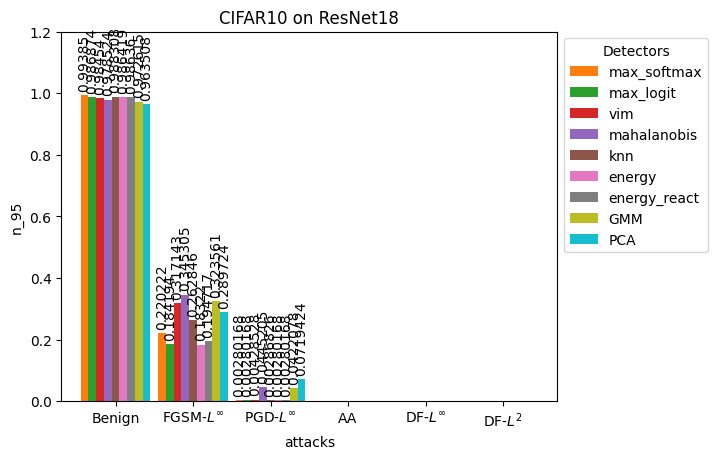

In [ ]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[ method] = table[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("CIFAR10 on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95")

# plt.savefig(f"plots/100_attacked_{mode}_{model}_95.png", bbox_inches='tight', dpi=300)

Text(0, 0.5, 'n_95_frac')

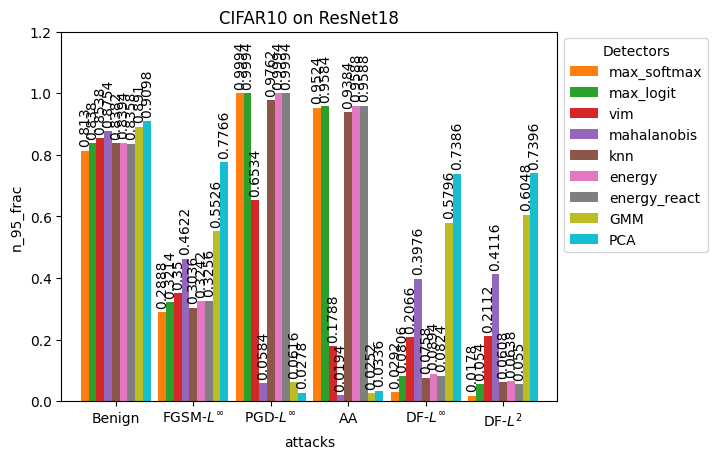

In [ ]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[method] = table_frac[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("CIFAR10 on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95_frac")

# plt.savefig(f"plots/100_attacked_{mode}_{model}_95_frac.png", bbox_inches='tight', dpi=300)

Text(0, 0.5, 'n_95')

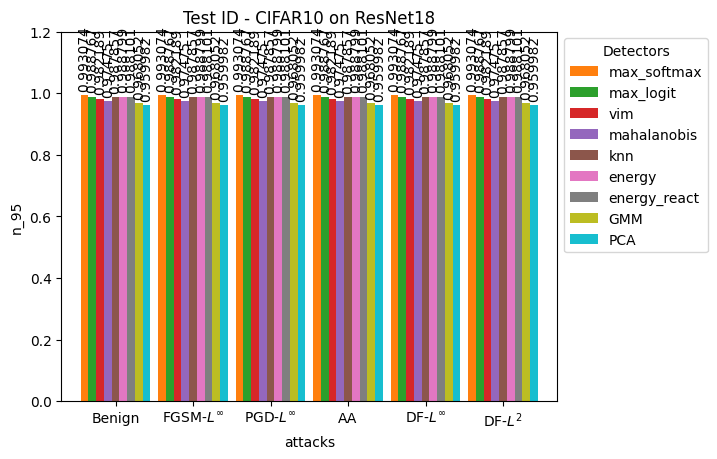

In [ ]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[ method] = table_id_test[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("Test ID - CIFAR10 on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95")
# plt.savefig(f"plots/100_attacked_{mode}_{model}_95.png", bbox_inches='tight', dpi=300)

Text(0, 0.5, 'n_95_frac')

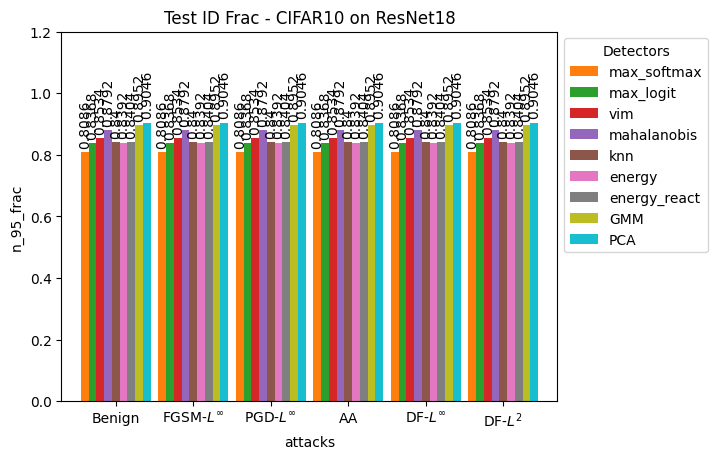

In [12]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[method] = table_id_test_frac[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                       textcoords="offset points", ha="center", va="bottom")

plt.title("Test ID Frac - CIFAR10 on ResNet18")
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95_frac")
# plt.savefig(f"plots/100_attacked_{mode}_{model}_95_frac.png", bbox_inches='tight', dpi=300)

# Invetigate impact of vim score_ood = -vlogit_ood + alpha*energy_ood

In [13]:
metrics = ['quantiles']
results = {}
results_frac = {}
results_id_test = {}
results_id_test_frac = {}
# attacks = ['fgsm']
attacks = ['nor']
# attacks = ['nor', 'fgsm', 'linfpgd', 'aa', 'linfdf', 'l2df']

# score_fct = ["max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM",  "PCA"]
score_fct = ["vim"]
# attacks = ['pgd']
# score_fct = [ "vim" ]
lambdas = [0.1, 0.5, 1, 2]
# alphas = [0.001, 1, 10]

In [14]:
# features_ood_clean = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[5000:6000]
# logits_ood_clean = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[5000:6000]
# labels_ood_clean = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[5000:6000]

for it, attack in enumerate(attacks):
    print("attack: ", attack)
    results[attack] = {}
    results_frac[attack] = {}
    results_id_test[attack] = {}
    results_id_test_frac[attack] = {}
    
    if it == 0:
        features_ood = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[5000:]
        logits_ood = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[5000:]
        labels_ood = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[5000:]
    else:
        features_ood = np.squeeze(torch.load(f"{dataset_path}/spatial/features_{attack}_{mode}_{model}_test.pt"))[5000:]
        logits_ood = torch.load(f"{dataset_path}/spatial/logits_{attack}_{mode}_{model}_test.pt")[5000:]
        labels_ood = torch.load(f"{dataset_path}/spatial/labels_{attack}_{mode}_{model}_test.pt")[5000:]
    
    # if it == 0:
    #     features_ood = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[6000:]
    #     logits_ood = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[6000:]
    #     labels_ood = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[6000:]
    # else:
    #     features_ood = np.squeeze(torch.load(f"{dataset_path}/spatial/features_{attack}_{mode}_{model}_test.pt"))[6000:]
    #     logits_ood = torch.load(f"{dataset_path}/spatial/logits_{attack}_{mode}_{model}_test.pt")[6000:]
    #     labels_ood = torch.load(f"{dataset_path}/spatial/labels_{attack}_{mode}_{model}_test.pt")[6000:]
    
    # features_ood = np.vstack((features_ood_clean, features_ood))
    # logits_ood = np.vstack((logits_ood_clean, logits_ood))
    # labels_ood = np.concatenate((labels_ood_clean, labels_ood))
    
    for it2, score_function_name in enumerate(score_fct):

        results[attack][score_function_name]              = {}
        results_frac[attack][score_function_name]         = {}
        results_id_test[attack][score_function_name]      = {}
        results_id_test_frac[attack][score_function_name] = {}
        results[attack][score_function_name]['lambda']               = {}
        results_frac[attack][score_function_name]['lambda']          = {}
        results_id_test[attack][score_function_name]['lambda']       = {} 
        results_id_test_frac[attack][score_function_name]['lambda']  = {} 
        
        for l in lambdas: 
            scores_id_val, score_function = create_score_function(
                features_id_train,
                logits_id_train,
                labels_id_train,
                features_id_val,
                logits_id_val,
                labels_id_val,
                w,
                b,
                score_function =  score_function_name,
                lam1=l,
                **config
            )

            
            scores_id_train = score_function(features_id_train, logits_id_train, lam2=l)
            scores_id_test  = score_function(features_id_test, logits_id_test, lam2=l)
            scores_ood_test = score_function(features_ood, logits_ood, lam2=l)

            outs = compute_metric(
                scores_id_val,
                scores_id_test,
                scores_ood_test,
                features_id_train,
                logits_id_train,
                labels_id_train,
                features_id_test,
                logits_id_test,
                labels_id_test,
                features_ood,
                logits_ood,
                labels_ood,
                metrics=metrics
            )

            results[attack][score_function_name]['lambda'][l] = outs['n_95']
            results_frac[attack][score_function_name]['lambda'][l] = outs['n_95_frac'] 
            results_id_test[attack][score_function_name]['lambda'][l] = outs['n_95_id_test']    
            results_id_test_frac[attack][score_function_name]['lambda'][l] = outs['n_95_frac_id_test']
        
keys = list(results.keys())
methods  = list(results[keys[0]].keys())

table = {}
table_frac = {}

for method in methods: 
    table[method] = []
    table_frac[method] = []
    
    for  key in keys:
        table[method].append(results[key][method])
        table_frac[method].append(results_frac[key][method])

attack:  nor
lam1 0.1
lam2:  0.1
lam2:  0.1
lam2:  0.1
lam1 0.5
lam2:  0.5
lam2:  0.5
lam2:  0.5
lam1 1
lam2:  1
lam2:  1
lam2:  1
lam1 2
lam2:  2
lam2:  2
lam2:  2


In [15]:
raw_data = ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$']

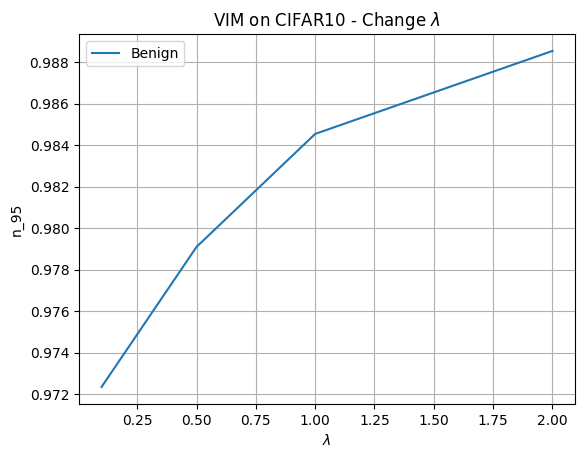

In [16]:
plt.figure()

for it, (key, value) in enumerate(results.items()):
    alpha_val = list(value['vim']['lambda'].keys())
    value_val = list(value['vim']['lambda'].values())
    plt.plot(alpha_val, value_val, label=raw_data[it])

# plt.xticks(range(len(lambdas)), lambdas)
plt.xlabel('$\lambda$')
plt.ylabel('n_95')
plt.title('VIM on CIFAR10 - Change $\lambda$')
plt.legend()
plt.grid()
plt.show()

# plt.savefig(f"plots/vim_cifar10_spatial_resnet18_95_lambda.png", bbox_inches='tight', dpi=300)

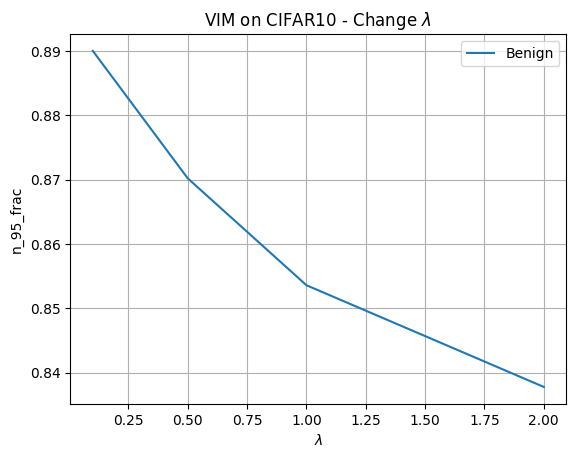

In [17]:
plt.figure()

for it, (key, value) in enumerate(results_frac.items()):
    lam_val = list(value['vim']['lambda'].keys())
    value_val = list(value['vim']['lambda'].values())
    plt.plot(lam_val, value_val, label=raw_data[it])

# plt.xticks(range(len(lambdas)), lambdas)
plt.xlabel('$\lambda$')
plt.ylabel('n_95_frac')
plt.title('VIM on CIFAR10 - Change $\lambda$')
plt.legend()
plt.grid()
plt.show()

# plt.savefig(f"plots/vim_cifar10_spatial_resnet18_95_lambda.png", bbox_inches='tight', dpi=300)

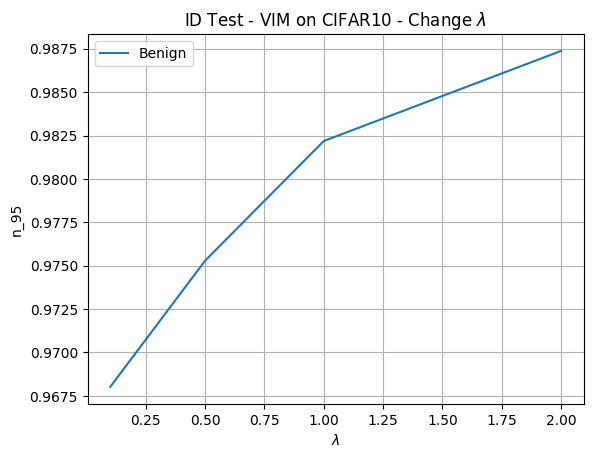

In [18]:
plt.figure()

for it, (key, value) in enumerate(results_id_test.items()):
    alpha_val = list(value['vim']['lambda'].keys())
    value_val = list(value['vim']['lambda'].values())
    plt.plot(alpha_val, value_val, label=raw_data[it])

# plt.xticks(range(len(lambdas)), lambdas)
plt.xlabel('$\lambda$')
plt.ylabel('n_95')
plt.title('ID Test - VIM on CIFAR10 - Change $\lambda$')
plt.legend()
plt.grid()
plt.show()

# plt.savefig(f"plots/vim_cifar10_spatial_resnet18_95_lambda.png", bbox_inches='tight', dpi=300)

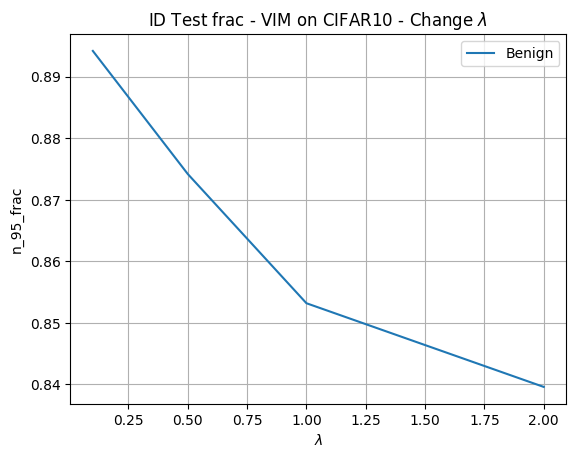

In [19]:
plt.figure()

for it, (key, value) in enumerate(results_id_test_frac.items()):
    lam_val = list(value['vim']['lambda'].keys())
    value_val = list(value['vim']['lambda'].values())
    plt.plot(lam_val, value_val, label=raw_data[it])

# plt.xticks(range(len(lambdas)), lambdas)
plt.xlabel('$\lambda$')
plt.ylabel('n_95_frac')
plt.title('ID Test frac - VIM on CIFAR10 - Change $\lambda$')
plt.legend()
plt.grid()
plt.show()

# plt.savefig(f"plots/vim_cifar10_spatial_resnet18_95_lambda.png", bbox_inches='tight', dpi=300)

### 1/5 are benign and 4/5 attacked

In [23]:
features_ood_clean = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[5000:6000]
logits_ood_clean = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[5000:6000]
labels_ood_clean = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[5000:6000]

for it, attack in enumerate(attacks):
    print("attack: ", attack)
    results[attack] = {}
    results_frac[attack] = {}
    results_id_test[attack] = {}
    results_id_test_frac[attack] = {}
    
    if it == 0:
        features_ood = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[6000:]
        logits_ood = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[6000:]
        labels_ood = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[6000:]
    else:
        features_ood = np.squeeze(torch.load(f"{dataset_path}/spatial/features_{attack}_{mode}_{model}_test.pt"))[6000:]
        logits_ood = torch.load(f"{dataset_path}/spatial/logits_{attack}_{mode}_{model}_test.pt")[6000:]
        labels_ood = torch.load(f"{dataset_path}/spatial/labels_{attack}_{mode}_{model}_test.pt")[6000:]
    
    features_ood = np.vstack((features_ood_clean, features_ood))
    logits_ood = np.vstack((logits_ood_clean, logits_ood))
    labels_ood = np.concatenate((labels_ood_clean, labels_ood))
    
    for it2, score_function_name in enumerate(score_fct):

        results[attack][score_function_name]              = {}
        results_frac[attack][score_function_name]         = {}
        results_id_test[attack][score_function_name]      = {}
        results_id_test_frac[attack][score_function_name] = {}
        results[attack][score_function_name]['lambda']               = {}
        results_frac[attack][score_function_name]['lambda']          = {}
        results_id_test[attack][score_function_name]['lambda']       = {} 
        results_id_test_frac[attack][score_function_name]['lambda']  = {} 
        
        for l in lambdas: 
            scores_id_val, score_function = create_score_function(
                features_id_train,
                logits_id_train,
                labels_id_train,
                features_id_val,
                logits_id_val,
                labels_id_val,
                w,
                b,
                score_function =  score_function_name,
                lam1=l,
                **config
            )

            
            scores_id_train = score_function(features_id_train, logits_id_train, lam2=l)
            scores_id_test  = score_function(features_id_test, logits_id_test, lam2=l)
            scores_ood_test = score_function(features_ood, logits_ood, lam2=l)

            outs = compute_metric(
                scores_id_val,
                scores_id_test,
                scores_ood_test,
                features_id_train,
                logits_id_train,
                labels_id_train,
                features_id_test,
                logits_id_test,
                labels_id_test,
                features_ood,
                logits_ood,
                labels_ood,
                metrics=metrics
            )

            results[attack][score_function_name]['lambda'][l] = outs['n_95']
            results_frac[attack][score_function_name]['lambda'][l] = outs['n_95_frac'] 
            results_id_test[attack][score_function_name]['lambda'][l] = outs['n_95_id_test']    
            results_id_test_frac[attack][score_function_name]['lambda'][l] = outs['n_95_frac_id_test']
        
keys = list(results.keys())
methods  = list(results[keys[0]].keys())

table = {}
table_frac = {}

for method in methods: 
    table[method] = []
    table_frac[method] = []
    
    for  key in keys:
        table[method].append(results[key][method])
        table_frac[method].append(results_frac[key][method])

attack:  nor
lam1 0.1
lam2:  0.1
lam2:  0.1
lam2:  0.1
lam1 0.5
lam2:  0.5
lam2:  0.5
lam2:  0.5
lam1 1
lam2:  1
lam2:  1
lam2:  1
lam1 2
lam2:  2
lam2:  2
lam2:  2


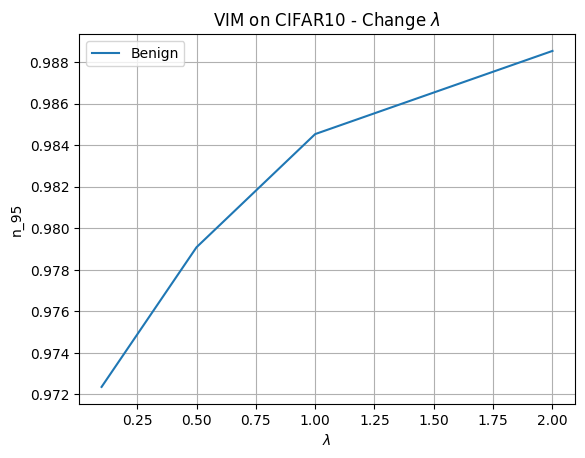

In [24]:
plt.figure()

for it, (key, value) in enumerate(results.items()):
    alpha_val = list(value['vim']['lambda'].keys())
    value_val = list(value['vim']['lambda'].values())
    plt.plot(alpha_val, value_val, label=raw_data[it])

# plt.xticks(range(len(lambdas)), lambdas)
plt.xlabel('$\lambda$')
plt.ylabel('n_95')
plt.title('VIM on CIFAR10 - Change $\lambda$')
plt.legend()
plt.grid()
plt.show()

# plt.savefig(f"plots/vim_cifar10_spatial_resnet18_95_lambda.png", bbox_inches='tight', dpi=300)

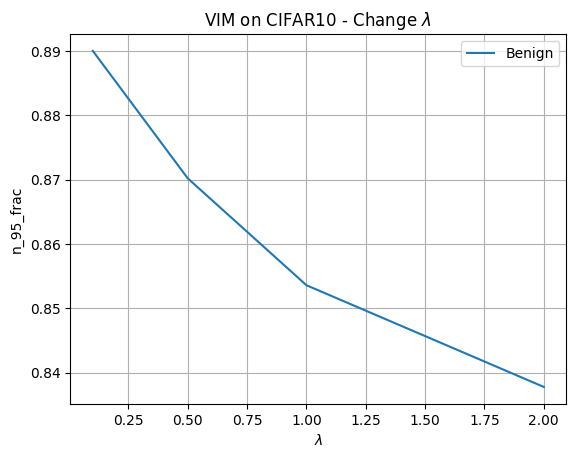

In [25]:
plt.figure()

for it, (key, value) in enumerate(results_frac.items()):
    lam_val = list(value['vim']['lambda'].keys())
    value_val = list(value['vim']['lambda'].values())
    plt.plot(lam_val, value_val, label=raw_data[it])

# plt.xticks(range(len(lambdas)), lambdas)
plt.xlabel('$\lambda$')
plt.ylabel('n_95_frac')
plt.title('VIM on CIFAR10 - Change $\lambda$')
plt.legend()
plt.grid()
plt.show()

# plt.savefig(f"plots/vim_cifar10_spatial_resnet18_95_lambda.png", bbox_inches='tight', dpi=300)